<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Game-features-and-rendering" data-toc-modified-id="Game-features-and-rendering-1">Game features and rendering</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Play-a-game" data-toc-modified-id="Play-a-game-1.3">Play a game</a></span></li><li><span><a href="#Features" data-toc-modified-id="Features-1.4">Features</a></span><ul class="toc-item"><li><span><a href="#Map-features" data-toc-modified-id="Map-features-1.4.1">Map features</a></span><ul class="toc-item"><li><span><a href="#Rows-and-cols-convention" data-toc-modified-id="Rows-and-cols-convention-1.4.1.1">Rows and cols convention</a></span></li><li><span><a href="#Specification" data-toc-modified-id="Specification-1.4.1.2">Specification</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.4.1.3">Implementation</a></span></li></ul></li><li><span><a href="#Global-features" data-toc-modified-id="Global-features-1.4.2">Global features</a></span></li></ul></li><li><span><a href="#Rendering-the-features" data-toc-modified-id="Rendering-the-features-1.5">Rendering the features</a></span><ul class="toc-item"><li><span><a href="#Icons" data-toc-modified-id="Icons-1.5.1">Icons</a></span></li><li><span><a href="#Working-with-images" data-toc-modified-id="Working-with-images-1.5.2">Working with images</a></span></li><li><span><a href="#Rendering" data-toc-modified-id="Rendering-1.5.3">Rendering</a></span></li></ul></li></ul></li></ul></div>

# Game features and rendering

## Goal

The goal of this notebook is to study which features are necessary for playing, and to find a nice way to render them.

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [73]:
import os
import glob
import random
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from kaggle_environments import make, evaluate
from functools import partial
from IPython.display import clear_output
from tqdm.notebook import tqdm

from kaggle_environments.envs.lux_ai_2021.test_agents.python.lux.game import Game

from luxai.utils import render_game_in_html, set_random_seed

In [74]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (20, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Play a game

In [4]:
set_random_seed(7)
env = make("lux_ai_2021", debug=True, 
           configuration={'width': 12, 'height': 12, 'seed': 0, 
                          'episodeSteps': 361, 'annotations':True})
game_info = env.run(['../agents/working_title/agent.py', '../agents/viral.py'])
render_game_in_html(env)

Opening in existing browser session.


In [5]:
def get_game_state_for_epoch(game_info, epoch):
    for step_info in game_info[:epoch]:
        observation = step_info[0]['observation']
        if observation["step"] == 0:
            game_state = Game()
            game_state._initialize(observation["updates"])
            game_state._update(observation["updates"][2:])
            game_state.id = observation.player
        else:
            game_state._update(observation["updates"])
    return game_state

## Features

I think we need to have two kind of features:

- Map related features. These features need to be defined for each cell in the map
- Global features. This affect to all the cells. F.e. research points or the turn

### Map features

#### Rows and cols convention

![](https://raw.githubusercontent.com/Lux-AI-Challenge/Lux-Design-2021/master/assets/game_board.png)

In the representation the square is rotated 45º. X dimension is on WE axis and Y dimension is on NS axis.

- Increasing x means moving east
- Increasing y means moving south

We can represent that in a image with y on heigh and x on width. For python convention y will use the first axis.

#### Specification

- [x] Each resource should be represented on each own channel. Each cell will store the amount of resources
- [x] Each player should have 3 channels for cities, workers and carts
- [ ] We should have 4 channels with the information of wood, coal, uranium and fuel that each worker/city has. Maybe is better to just say how much material and fuel it has.
- [x] We need another channel for cooldown
- [ ] Having information about how many turns can an agent survive at night would be also useful. To know that I need the exact cargo of the agent
- [ ] A map showing how much material and fuel can gather an agent in a turn would also be useful

#### Implementation

In [52]:
channels_map = dict(
    wood=0, coal=1, uranium=2, 
    player0_worker=3, player0_cart=4, player0_city=5,
    player1_worker=6, player1_cart=7, player1_city=8,
    cooldown = 9,
)
assert(len(channels_map) == len(np.unique(list(channels_map.values()))))
unit_number_to_name = {0: 'worker', 1: 'cart'}

def create_feature_maps(game_state):
    feature_maps = np.zeros((game_state.map_height, game_state.map_width, len(channels_map)), float)
    add_resources_to_feature_maps(feature_maps, game_state)
    add_player_units(feature_maps, game_state)
    return feature_maps

def add_resources_to_feature_maps(feature_maps, game_state):
    for x in range(game_state.map_width):
        for y in range(game_state.map_height):
            cell = game_state.map.get_cell(x, y)
            if cell.has_resource():
                feature_maps[y, x, channels_map[cell.resource.type]] = cell.resource.amount

def add_player_units(feature_maps, game_state):
    for player_idx, player in enumerate(game_state.players):
        for unit in player.units:
            channel = channels_map['player%i_%s' % (player_idx, unit_number_to_name[unit.type])]
            feature_maps[unit.pos.y, unit.pos.x, channel] += 1
            feature_maps[unit.pos.y, unit.pos.x, channels_map['cooldown']] += unit.cooldown
        for city in player.cities.values():
            for city_tile in city.citytiles:
                channel = channels_map['player%i_city' % player_idx]
                feature_maps[city_tile.pos.y, city_tile.pos.x, channel] += 1
                feature_maps[city_tile.pos.y, city_tile.pos.x, channels_map['cooldown']] += city_tile.cooldown

In [57]:
game_state = get_game_state_for_epoch(game_info, 3)
feature_maps = create_feature_maps(game_state)

feature_maps[:, :, channels_map['cooldown']]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 8., 0., 0., 0., 0., 0., 0., 8., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Global features

## Rendering the features

### Icons

I have gathered icons of the different objects to render the game. I have to find how to load them, resize and stack.

### Working with images

In [102]:
def stack_images(bottom, top):
    img = bottom.copy()
    mask = top[:, :, 3]
    for idx in range(4):
        img[:, :, idx] = img[:, :, idx]*(1.-mask) + mask*top[:, :, idx]
    return img    

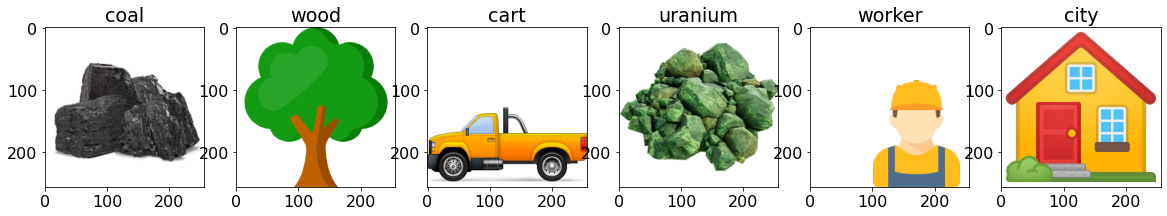

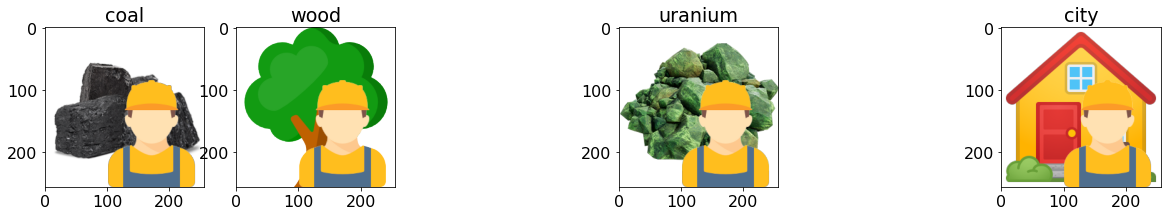

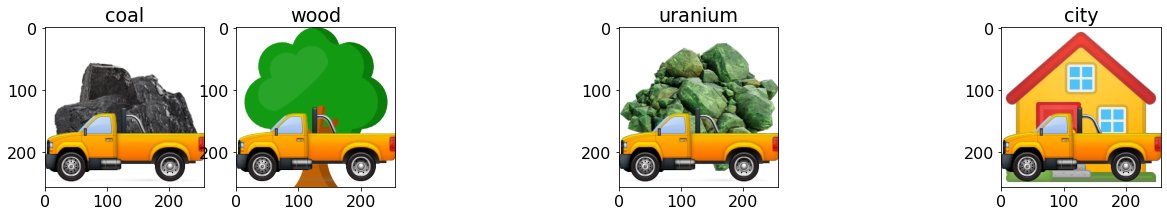

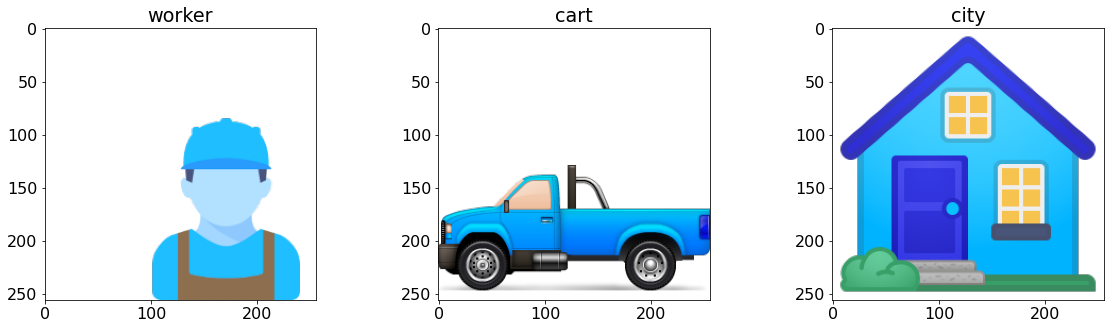

In [116]:
img_paths = glob.glob('/home/gbarbadillo/Desktop/luxai_icons/*.png')
icons = {os.path.splitext(os.path.basename(img_path))[0]: plt.imread(img_path) for img_path in img_paths}

for idx, (name, img) in enumerate(icons.items()):
    plt.subplot(1, len(icons), idx+1)
    plt.imshow(img)
    plt.title(name)
plt.show()

units = ['worker', 'cart']
for unit in units:
    for idx, (name, img) in enumerate(icons.items()):
        if name in units:
            continue
        plt.subplot(1, len(icons), idx+1)
        plt.title(name)
        plt.imshow(stack_images(img, icons[unit]))
    plt.show()
    
player_units = ['worker', 'cart', 'city']
for idx, name in enumerate(player_units):
    plt.subplot(1, len(player_units), idx+1)
    plt.imshow(icons[name][:, :, [2, 1, 0, 3]])
    plt.title(name)

### Rendering

Now that it's time to render I'm not sure if creating the features was the best way to later rendering. I think it might be better to still use the game state.

I will create an image for each cell and at the end concatenate all of them.

In [153]:
def render_game_state(game_state):
    cell_images = create_cell_images(game_state)
    add_player_info(cell_images)
    add_grid(cell_images)
    return combine_cells_to_single_image(cell_images)

def create_cell_images(game_state, img_size=256):
    cell_images = []
    for y in range(game_state.map_height):
        row = []
        for x in range(game_state.map_width):
            cell = game_state.map.get_cell(x, y)
            if cell.has_resource():
                row.append(icons[cell.resource.type])
                #cell.resource.amount
            else:
                row.append(np.zeros((img_size, img_size, 4)))
        cell_images.append(row)
    return cell_images

def add_player_info(cell_images):
    for player_idx, player in enumerate(game_state.players):
        for city in player.cities.values():
            for city_tile in city.citytiles:
                img_base = cell_images[city_tile.pos.y][city_tile.pos.x]
                cell_images[city_tile.pos.y][city_tile.pos.x] = stack_images(img_base, apply_player_color(icons['city'], player_idx))

        for unit in player.units:
            img_base = cell_images[unit.pos.y][unit.pos.x]
            cell_images[unit.pos.y][unit.pos.x] = stack_images(img_base, apply_player_color(icons[unit_number_to_name[unit.type]], player_idx))

def apply_player_color(icon, player_idx):
    if player_idx:
        return icon[:, :, [2, 1, 0, 3]]
    else:
        return icon
    
def add_grid(cell_images, thickness=2, grid_color=(0, 0, 0, 1)):
    for row in cell_images:
        for img in row:
            img[:thickness] = grid_color
            img[:, :thickness] = grid_color
            img[-thickness:] = grid_color
            img[:, -thickness:] = grid_color
    
def combine_cells_to_single_image(cell_images):
    rows = [np.hstack(row) for row in cell_images]
    return np.vstack(rows)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


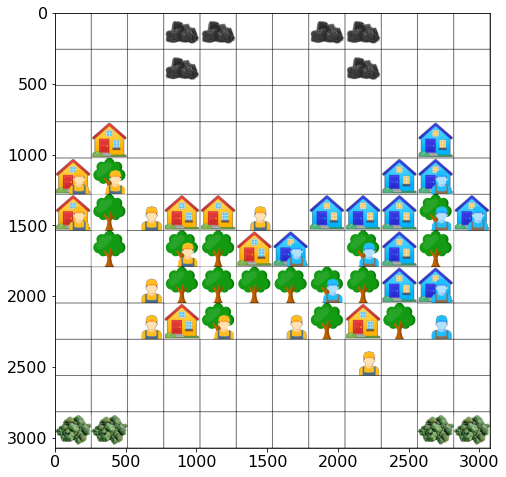

In [154]:
game_state = get_game_state_for_epoch(game_info, 45)
plt.figure(figsize=(8, 8))
plt.imshow(render_game_state(game_state));